In [1]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q textstat
!pip install -q googletrans

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

Using TensorFlow backend.


In [3]:
DATA_PATH = "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/"
os.listdir(DATA_PATH)
TEST_PATH = DATA_PATH + "test.csv"
VAL_PATH = DATA_PATH + "validation.csv"
TRAIN_PATH = DATA_PATH + "jigsaw-toxic-comment-train.csv"

val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [4]:
val = val_data
train = train_data

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

val["comment_text"] = clean(val["comment_text"])
test_data["content"] = clean(test_data["content"])
train["comment_text"] = clean(train["comment_text"])

In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [6]:
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [7]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

EPOCHS = 2
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', 
                                        lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [9]:
x_train = fast_encode(train.comment_text.astype(str), 
                      fast_tokenizer, maxlen=512)
x_valid = fast_encode(val_data.comment_text.astype(str).values, 
                      fast_tokenizer, maxlen=512)
x_test = fast_encode(test_data.content.astype(str).values, 
                     fast_tokenizer, maxlen=512)

y_valid = val.toxic.values
y_train = train.toxic.values

In [10]:
print(x_train)

[[  101 88840 31237 ...     0     0     0]
 [  101   172   112 ...     0     0     0]
 [  101 10261 10157 ...     0     0     0]
 ...
 [  101   134   134 ...     0     0     0]
 [  101 10911 10161 ...     0     0     0]
 [  101   107   134 ...     0     0     0]]


In [11]:
train.comment_text.astype(str)

0         explanation why the edits made under my userna...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         " more i can't make any real suggestions on im...
4         you, sir, are my hero. any chance you remember...
                                ...                        
223544    :jerome, i see you never got around to this…! ...
223545    ==lucky bastard==   http://wikimediafoundation...
223546    ==shame on you all!!!==    you want to speak a...
223547    mel gibson is a nazi bitch who makes shitty mo...
223548    "    == unicorn lair discovery ==    supposedl...
Name: comment_text, Length: 223549, dtype: object

In [14]:
print(x_train.shape)

(223549, 512)


In [13]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)


In [16]:
def build_distilbert_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    cls_token = Dense(500, activation="elu")(cls_token)
    cls_token = Dropout(0.1)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1.5e-5), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [19]:
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-multilingual-cased')
    model_distilbert = build_distilbert_model(transformer_layer, max_len=512)

model_distilbert.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 512, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 500)               384500    
_________________________________________________________________
dropout_19 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 135,119,081
Trainable params: 135,119,081
Non-trainable params: 0
______________________________________________

In [21]:
def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.3, patience=3, 
                                    verbose=1, mode='auto', 
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_valid, y_valid), interval=1)
    cb.append(RocAuc)
    
    return cb

In [23]:
calls = callback()
N_STEPS = x_train.shape[0] // BATCH_SIZE
train_history = model_distilbert.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

Train for 873 steps, validate for 32 steps
Epoch 1/2
872/873 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9479
 ROC-AUC - epoch: 1 - score: 0.801849
873/873 [==============================] - 419s 480ms/step - loss: 0.1358 - accuracy: 0.9479 - val_loss: 0.4491 - val_accuracy: 0.8478
Epoch 2/2
872/873 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9627
 ROC-AUC - epoch: 2 - score: 0.802373
873/873 [==============================] - 355s 406ms/step - loss: 0.0921 - accuracy: 0.9627 - val_loss: 0.5668 - val_accuracy: 0.8476


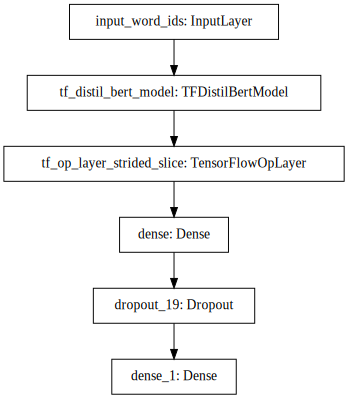

In [24]:
SVG(tf.keras.utils.model_to_dot(model_distilbert, dpi=70).create(prog='dot', format='svg'))

In [26]:
translator = Translator()

def visualize_model_preds(model, indices=[0, 17, 1, 24]):
    comments = val_data.comment_text.loc[indices].values.tolist()
    preds = model.predict(x_valid[indices].reshape(len(indices), -1))

    for idx, i in enumerate(indices):
        if y_valid[i] == 0:
            label = "Non-toxic"
            color = f'{Fore.GREEN}'
            symbol = '\u2714'
        else:
            label = "Toxic"
            color = f'{Fore.RED}'
            symbol = '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')
        print("ORIGINAL")
        print(comments[idx]); print("")
        print("TRANSLATED")
        print(translator.translate(comments[idx]).text)
        fig = go.Figure()
        if list.index(sorted(preds[:, 0]), preds[idx][0]) > 1:
            yl = [preds[idx][0], 1 - preds[idx][0]]
        else:
            yl = [1 - preds[idx][0], preds[idx][0]]
        fig.add_trace(go.Bar(x=['Non-Toxic', 'Toxic'], y=yl, marker=dict(color=["seagreen", "indianred"])))
        fig.update_traces(name=comments[idx])
        fig.update_layout(xaxis_title="Labels", yaxis_title="Probability", template="plotly_white", title_text="Predictions for validation comment #{}".format(idx+1))
        fig.show()

In [27]:
visualize_model_preds(model_distilbert)

1. Non-toxic ✔

ORIGINAL
este usuario ni siquiera llega al rango de    hereje   . por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión.    skipe linkin 22px   honor, valor, leltad.      17:48 13 mar 2008 (utc)

TRANSLATED
This user does not even rank heretic. therefore it should be burned at the barbecue to purify his soul and our digestive tract by ingestion. skipe linkin 22px honor, courage, leltad. 13 Mar 2008 17:48 (UTC)


2. Toxic ✖

ORIGINAL
in riguardo a cio  che ho pubblicato e tu hai già tolto dai maroni. lo trovo ingiusto e un po  comunista. sei pregato di non scassarmi il cazzo, e te lo chiedo gentilemnte. 

TRANSLATED
in regard to what I posted and you've already removed from the Maronites. I find it unfair and a little Communist. please do not scassarmi cock, and I ask gentilemnte.


3. Non-toxic ✔

ORIGINAL
il testo di questa voce pare esser scopiazzato direttamente da qui. immagino possano esserci problemi di copyright, nel fare cio .

TRANSLATED
the text of this item seems to be plagiarized directly from here. I guess there may be copyright issues in doing what.


4. Toxic ✖

ORIGINAL
razza di idioti!!! vi siete bevuti il cervello???? cos è questa intromissione????? le vostre beghe personali risolvetele nelle vostre pagine (personali)! in più, io ho votato per la cancellazione!!! quindi andate a .....lo! 

TRANSLATED
breed of idiots !!! you have drunk the brain ???? so is this meddling ????? your personal squabbles risolvetele in your pages (personal)! in addition, I have voted for the cancellation !!! so go ..... it!


In [28]:
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sub['toxic'] = model_distilbert.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

250/250 [==============================] - 44s 176ms/step
